In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from IPython.display import Audio
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import accuracy_score,log_loss, confusion_matrix,ConfusionMatrixDisplay
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
dirname = '../input/dysarthria-detection'        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dysarthria-detection/torgo_data/data.csv
/kaggle/input/dysarthria-detection/torgo_data/dysarthria_male/M05_Session2_0075.wav
/kaggle/input/dysarthria-detection/torgo_data/dysarthria_male/M02_Session1_0078.wav
/kaggle/input/dysarthria-detection/torgo_data/dysarthria_male/M01_Session2_3_0057.wav
/kaggle/input/dysarthria-detection/torgo_data/dysarthria_male/M03_Session2_0111.wav
/kaggle/input/dysarthria-detection/torgo_data/dysarthria_male/M02_Session1_0066.wav
/kaggle/input/dysarthria-detection/torgo_data/dysarthria_male/M05_Session2_0371.wav
/kaggle/input/dysarthria-detection/torgo_data/dysarthria_male/M03_Session2_0218.wav
/kaggle/input/dysarthria-detection/torgo_data/dysarthria_male/M03_Session2_0380.wav
/kaggle/input/dysarthria-detection/torgo_data/dysarthria_male/M05_Session2_0007.wav
/kaggle/input/dysarthria-detection/torgo_data/dysarthria_male/M05_Session2_0128.wav
/kaggle/input/dysarthria-detection/torgo_data/dysarthria_male/M02_Session2_0199.wav
/kaggle/input/dysar

In [2]:

import warnings
warnings.filterwarnings("ignore")

## Task 1. Read data.csv in pandas
[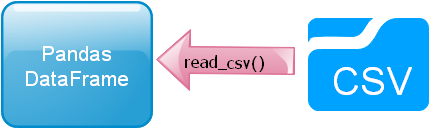!](http://)

In [3]:

d = pd.read_csv("../input/dysarthria-detection/torgo_data/data.csv")
d['filename'] = d['filename'].apply(lambda x: os.path.join(dirname,x))
d



is_dysarthria  gender  \
0     non_dysarthria  female   
1     non_dysarthria  female   
2     non_dysarthria  female   
3     non_dysarthria  female   
4     non_dysarthria  female   
...              ...     ...   
1995      dysarthria    male   
1996      dysarthria    male   
1997      dysarthria    male   
1998      dysarthria    male   
1999      dysarthria    male   

                                               filename  
0     ../input/dysarthria-detection/torgo_data/non_d...  
1     ../input/dysarthria-detection/torgo_data/non_d...  
2     ../input/dysarthria-detection/torgo_data/non_d...  
3     ../input/dysarthria-detection/torgo_data/non_d...  
4     ../input/dysarthria-detection/torgo_data/non_d...  
...                                                 ...  
1995  ../input/dysarthria-detection/torgo_data/dysar...  
1996  ../input/dysarthria-detection/torgo_data/dysar...  
1997  ../input/dysarthria-detection/torgo_data/dysar...  
1998  ../input/dysarthria-detection/torgo_data/dysar...  
1999  ../input/dysarthria-detection/torgo_data/dysar...  

[2000 rows x 3 columns]

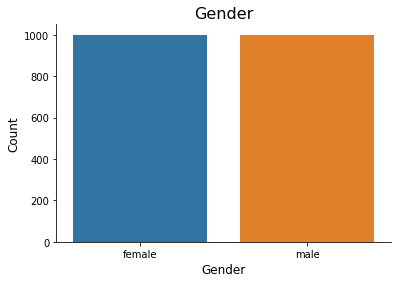

In [4]:
plt.title('Gender', size=16)
sns.countplot( d.gender)
plt.ylabel('Count', size=12)
plt.xlabel('Gender', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()



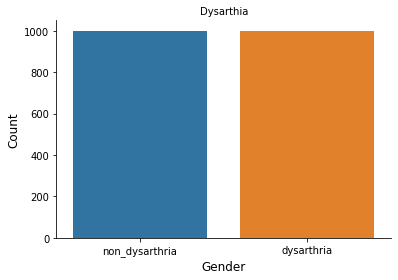

In [5]:
plt.title('Dysarthia', size=10)
sns.countplot( d.is_dysarthria)
plt.ylabel('Count', size=12)
plt.xlabel('Gender', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()




 ## Task 2:
## For any 1 random sample of dysarthric male, dysarthric female, non-dysarthric male, and non-dysarthric female, visualize
[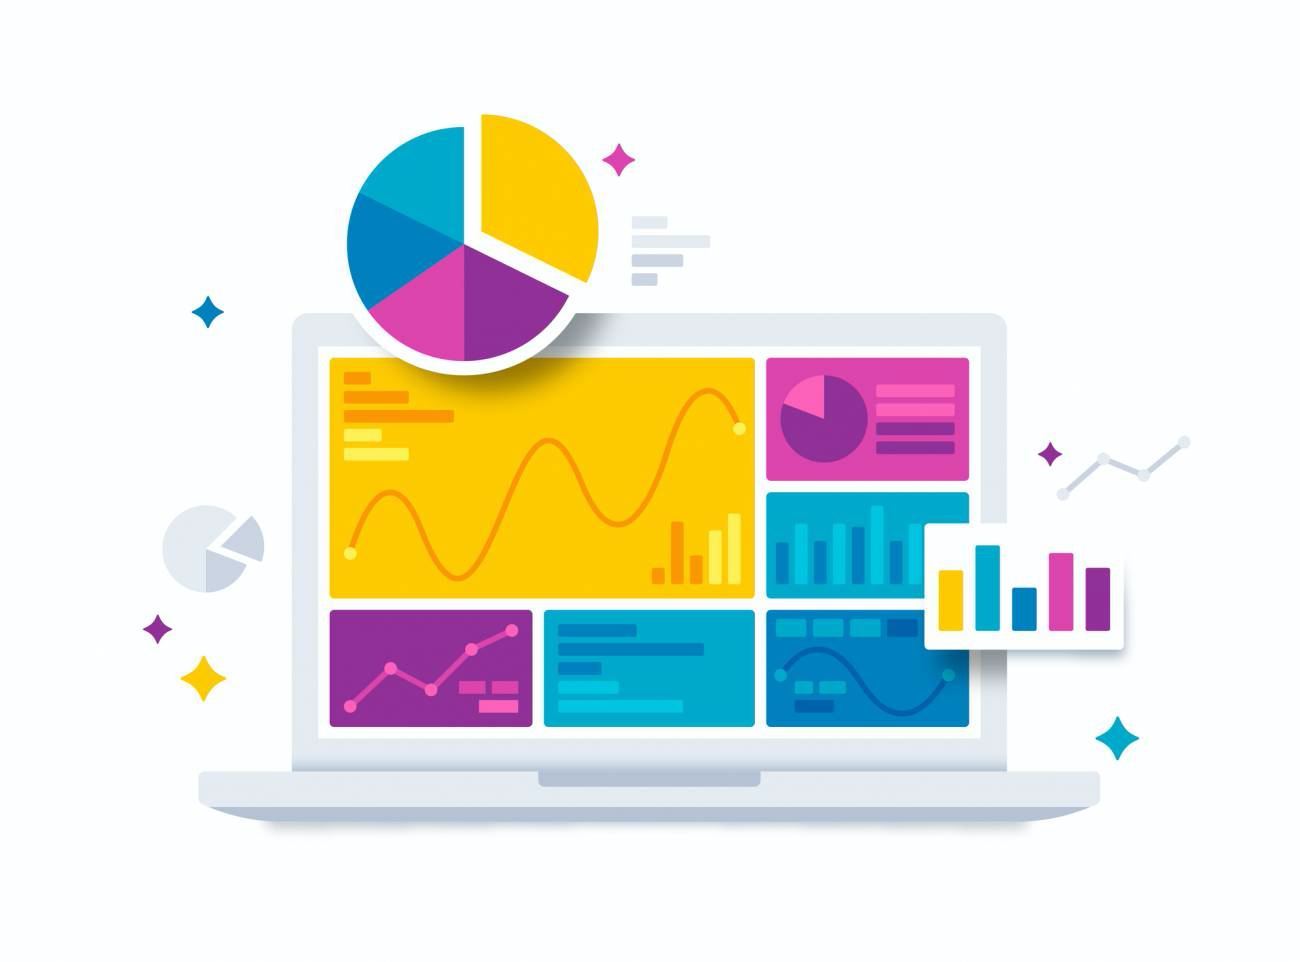](http://)
###  a. Waveplot
###  b. Spectrogram
###  c. Zero Crossing rate
###  d. Spectral Centroid and rolloff,
###  e. MFCC
###  f. Mel Spectrogram



In [6]:
def create_waveplot(data, sr, i):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {}'.format(i), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def create_mel_Spectogram(data, sr, i):
    plt.figure(figsize=(10, 3))
    plt.title('Mel Spectrogram of audio {} emotion'.format(i), size=15)
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr)
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time')
    plt.show()

    
def create_Spectogram(data, sr, i): # have to check which is spect on log
    
    plt.figure(figsize=(10, 3))
    plt.title('Spectrogram of audio {} '.format(i), size=15)
    X = librosa.stft(data)
    
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb,sr = sr, x_axis="time",y_axis = "log")
    plt.show() 
        
    
def create_Zero_crossing_rate(data, sr, i):
    
    zero_crossings = librosa.zero_crossings(data)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(10, 3))
    plt.title('Zero Crossing Rate of audio {} '.format(i), size=15)
    zcrs = librosa.feature.zero_crossing_rate(data)
    plt.plot(zcrs[0])
    plt.show()    
    
def create_mfcc(data, sr, i):
    
    plt.figure(figsize=(10, 3))
    plt.title('MFCC of audio {} '.format(i), size=15)
    mfccs = librosa.feature.mfcc(y=data, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.show()
    
def create_Spectral_rolloff(data, sr, i):
    
    plt.figure(figsize=(10, 3))
    plt.title('Spectral Rolloff of audio {} '.format(i), size=15)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=data, sr=sr)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(data, sr=sr, alpha=0.4)
    plt.plot(t, spectral_rolloff, color='r')
    plt.show()
   
    
def create_Spectral_centroid(data, sr, i):

    plt.figure(figsize=(10, 3))
    plt.title('Spectral Centroids of audio {} '.format(i), size=15)
    spectral_centroids = librosa.feature.spectral_centroid(data, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(data, sr=sr, alpha=0.4)
    plt.plot(t, spectral_centroids, color='r')
    plt.show()  

## Male with Dysarthia

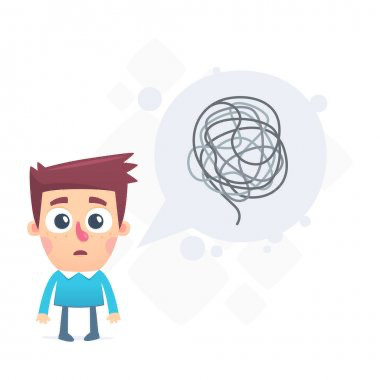!]

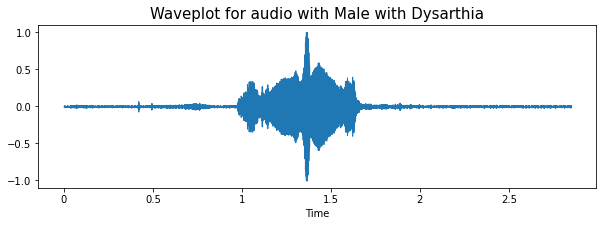

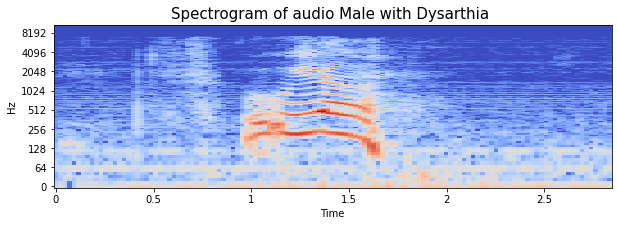

Sum of zero crossing  3290


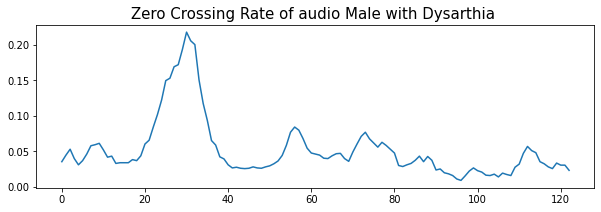

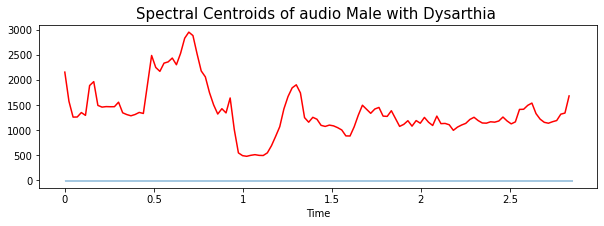

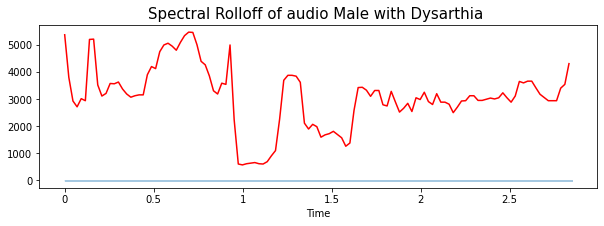

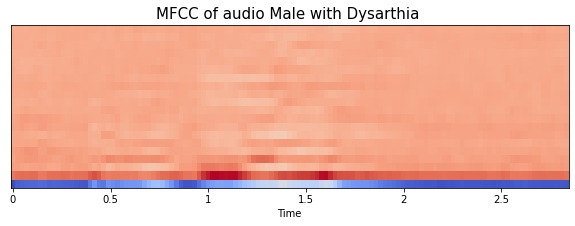

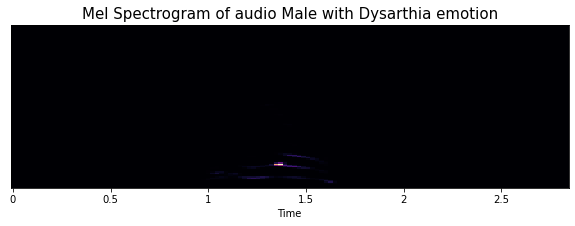

In [7]:
dysarthricMALE = d[(d['gender']=='male') & (d['is_dysarthria']=='dysarthria') ]
DM = dysarthricMALE.sample()
x= DM.iloc[0].filename
info= "Male with Dysarthia"
data, sampling_rate = librosa.load(x)
create_waveplot(data, sampling_rate, info)
create_Spectogram(data, sampling_rate, info)
create_Zero_crossing_rate(data, sampling_rate, info)
create_Spectral_centroid(data, sampling_rate, info)
create_Spectral_rolloff(data, sampling_rate, info)
create_mfcc(data, sampling_rate, info)
create_mel_Spectogram(data, sampling_rate, info)
Audio(x)


## Female with Dysarthia



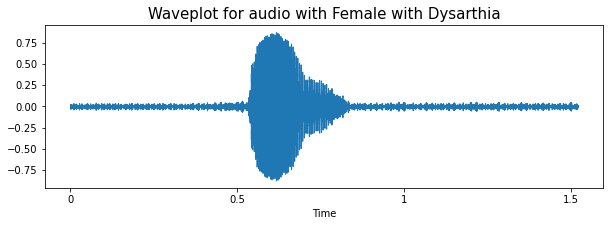

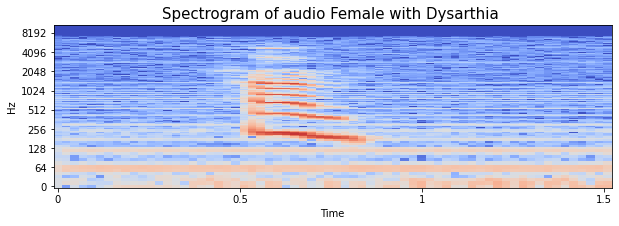

Sum of zero crossing  2736


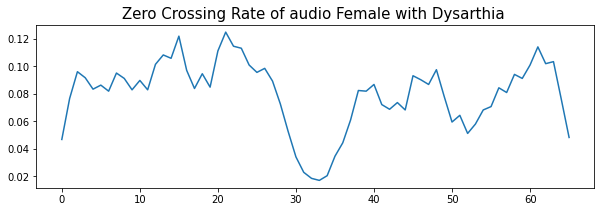

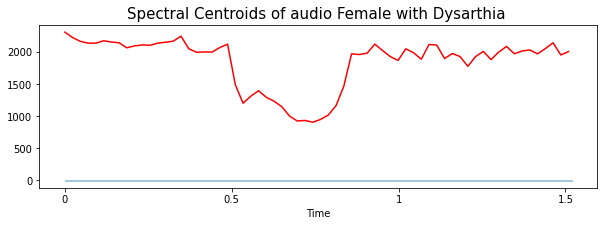

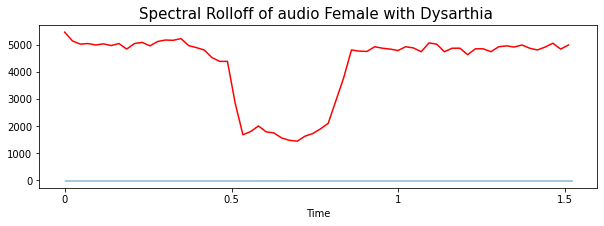

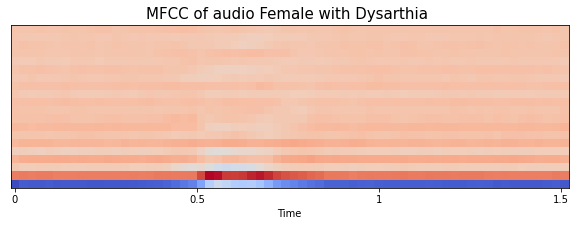

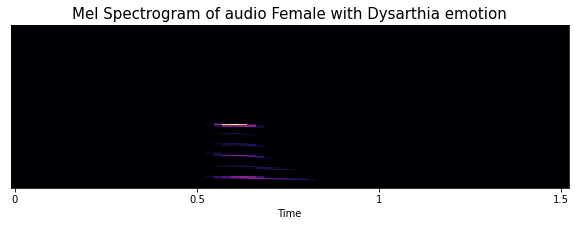

In [8]:
dysarthricFemale = d[(d['gender']=='female') & (d['is_dysarthria']=='dysarthria')]

DF = dysarthricFemale.sample()
x= DF.iloc[0].filename

info= "Female with Dysarthia"
data, sampling_rate = librosa.load(x)
create_waveplot(data, sampling_rate, info)
create_Spectogram(data, sampling_rate, info)
create_Zero_crossing_rate(data, sampling_rate, info)
create_Spectral_centroid(data, sampling_rate, info)
create_Spectral_rolloff(data, sampling_rate, info)
create_mfcc(data, sampling_rate, info)
create_mel_Spectogram(data, sampling_rate, info)
Audio(x)



## Male not with Dysarthia


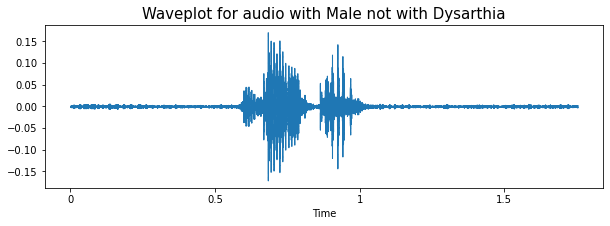

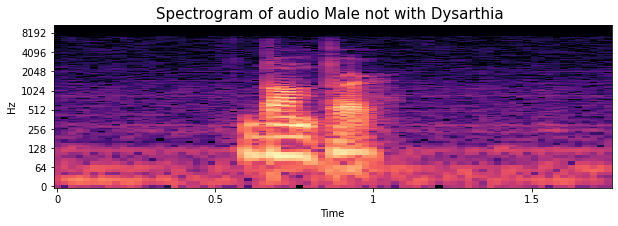

Sum of zero crossing  1341


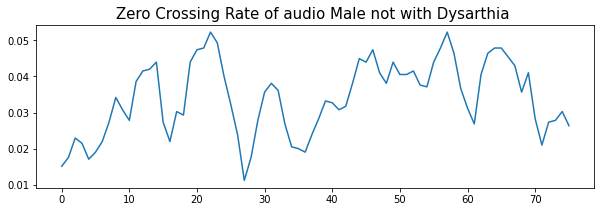

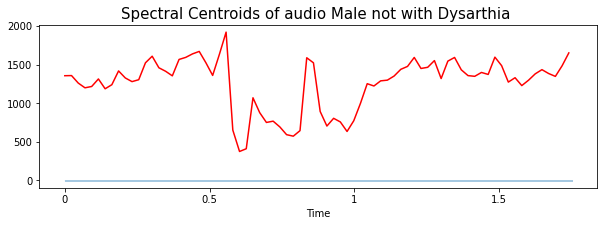

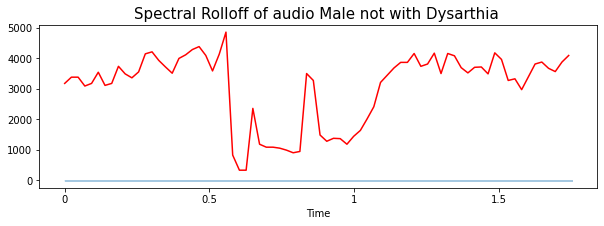

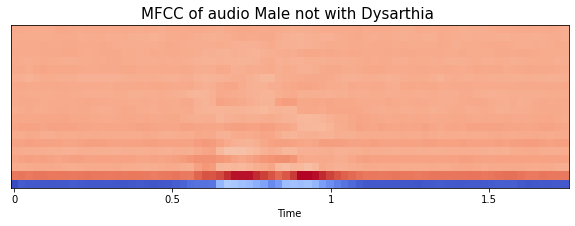

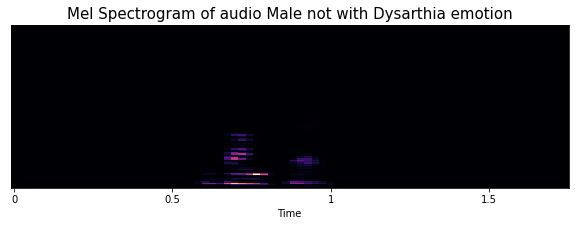

In [9]:
non_dysarthricMale  = d[(d['gender']=='male') & (d['is_dysarthria']=='non_dysarthria')]
NDM = non_dysarthricMale.sample()
v= NDM.iloc[0].filename
info= "Male not with Dysarthia"
data, sampling_rate = librosa.load(v)
create_waveplot(data, sampling_rate, info)
create_Spectogram(data, sampling_rate, info)
create_Zero_crossing_rate(data, sampling_rate, info)
create_Spectral_centroid(data, sampling_rate, info)
create_Spectral_rolloff(data, sampling_rate, info)
create_mfcc(data, sampling_rate, info)
create_mel_Spectogram(data, sampling_rate, info)

Audio(v)



## Female with Non-Dysarthia

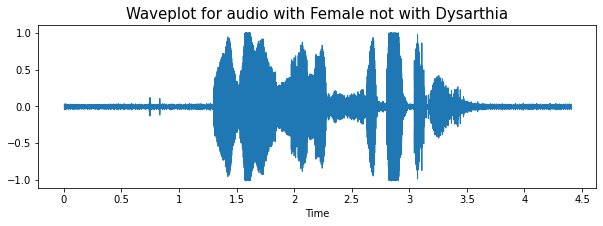

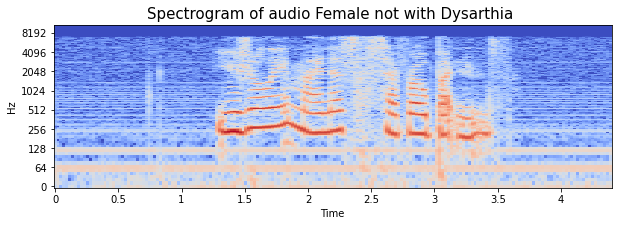

Sum of zero crossing  9776


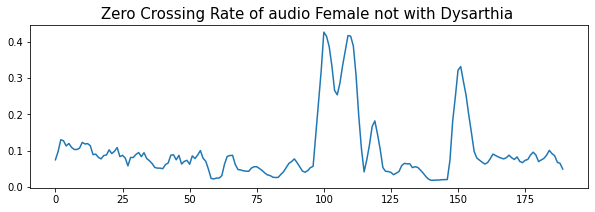

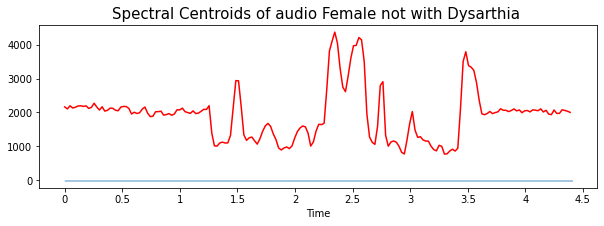

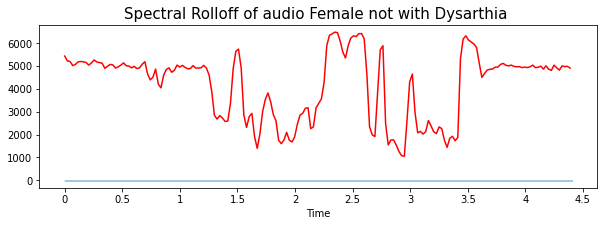

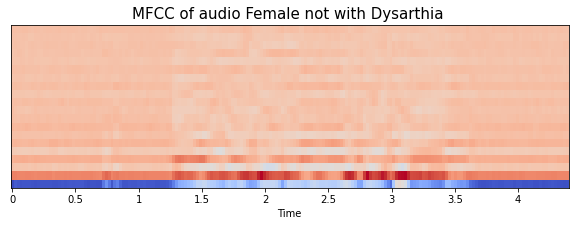

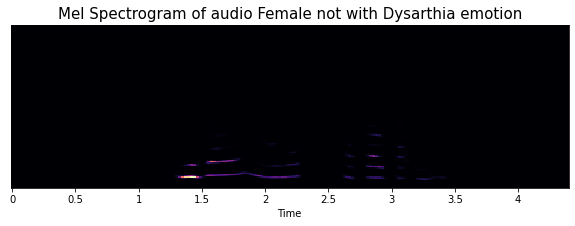

In [10]:
non_dysarthricFemale = d[(d['gender']=='female') & (d['is_dysarthria']=='non_dysarthria')]
NDF= non_dysarthricFemale.sample()
w= NDF.iloc[0].filename
info= "Female not with Dysarthia"
data, sampling_rate = librosa.load(w)
create_waveplot(data, sampling_rate, info)
create_Spectogram(data, sampling_rate, info)
create_Zero_crossing_rate(data, sampling_rate, info)
create_Spectral_centroid(data, sampling_rate, info)
create_Spectral_rolloff(data, sampling_rate, info)
create_mfcc(data, sampling_rate, info)
create_mel_Spectogram(data, sampling_rate, info)

Audio(w)



## Task 3. Comment on the output.

#### Waveplot: The male dysarthric waveplot has abrupt speech signal. The female dysarthric waveplot has abrupt speech  due to the words overlapping
The Non-dysarthric waveplot a  waveplot shows a normal speech waveplot
 
#### Spectrograms
The male and female dysarthric spectrograms have energy magnitudes of the frequencies which are more spread 
The Non dysarthric spectrograms have energy magnitudes that are narrow where they are speaking.

#### Zero Crossing Rate
The male and female dysarthrics Zero Crossing Rate have many peaks of zero crossing rate. It shows a  sudden increase of some words.
The Non dysarthric Zero Crossing Rate is high.

#### Spectral Centroid
The male and female dysarthrics spectral centroids, centroids go down for sometime then go again up.
The Non dysarthric spectral centroids, the centroids stay down for but where the they say something then go up again when they are silent.

#### Spectral Rolloff
Dysarthric Spectral Rolloff ,the 85% coverage below the rolloff frequency is there around the speech.
Non dysarthric Spectral Rolloff the 85% coverageis also at some other places.

#### MFCCs
Dysarthric MFCC is much more darker and concentrated
Non Dysarthric MFCC is more spread accross

### Mel Spectrogram
Dysarthric mel spectrograms show the abtruptness in speaking
Non Dysarthric  mel spectrograms show normal speech

## Task 4. Define a function to create 256 MFCC features for any given audio file.


Could have 128 maximum MFCCs

In [11]:
def mfcc_features_extract(x):

    features_mfcc = []
    try:
        x , sr = librosa.load(x)
        features_mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128)
        features_mfcc = np.mean(features_mfcc.T,axis=0)
    except:
        print('Error reading audio')
    return features_mfcc

In [12]:
N= d['filename'].apply(lambda a: mfcc_features_extract(a))


Error reading audio


In [13]:
N= N.tolist()
N= pd.DataFrame(N)

In [14]:
N.head(10)

0           1          2          3          4          5    \
0 -222.457077  102.146935 -17.265686  38.949039 -13.736136  20.581657   
1 -300.215210  110.792397 -17.835419  39.316513 -17.007551  22.735220   
2 -303.913361  113.325172 -24.710556  45.542671 -22.632982  26.017168   
3 -211.974976  117.983017 -36.248325  38.447906 -27.372046  25.304882   
4 -281.211090  105.812836 -18.269186  45.741081 -15.748901  27.830769   
5 -279.243713  101.549843 -14.545247  43.771034 -20.750765  28.204527   
6 -260.429626  106.949501 -18.940556  39.577473 -20.937639  25.124037   
7 -260.356628  119.570793 -12.621312  32.450829 -19.742584  17.546911   
8 -299.762238  111.119972 -21.424379  36.604053 -18.606598  23.688692   
9 -309.480896  117.617844 -25.670959  39.831596 -13.042587   4.185407   

         6          7         8         9    ...       118       119  \
0  -5.038507   9.669348  2.852035 -1.724100  ...  1.330539  0.959738   
1   2.369241  17.929928  4.389093  3.490597  ...  1.446290  1.091978   
2   1.537213  17.134033  5.634882  3.570631  ...  1.140907  0.793990   
3  -6.710573  11.927542  0.885225  2.587593  ...  1.135721  0.547349   
4  -2.712293  15.742901  5.896017  0.358894  ...  1.646695  1.533421   
5  -2.113040  16.293955  5.212938  2.370983  ...  1.105241  1.241872   
6  -0.150493  12.404461  0.519044  1.363603  ...  1.339865  1.123047   
7   2.765201   7.252509  0.462977  5.240708  ...  0.456419 -0.082434   
8   7.423238  20.190962  6.735855  4.014423  ...  1.404348  1.082514   
9 -11.869982  -5.867709 -1.187861 -0.437127  ...  0.693004  0.907460   

        120       121       122       123       124       125       126  \
0  0.782641  0.988810  0.482095 -0.025945  0.654508  0.499423  0.240431   
1  0.965665  1.435454 -0.224936 -1.078653 -0.329877  0.278370 -0.274176   
2  0.478094  1.164105 -0.163656 -1.209489  0.024640  0.433807 -0.406458   
3  0.990486  0.629700  0.259464 -0.164846  0.062285  0.314661 -0.045342   
4  0.922572  0.878170  0.324768  0.115258 -0.145911 -0.038609 -0.655331   
5  0.599105  0.809635  0.189292 -0.254489 -0.026493  0.275561 -0.573421   
6  0.886523  1.219861  0.469589 -0.129908  0.245215  0.710445 -0.097494   
7  0.334693  0.439577 -0.023259 -1.012125 -0.061827  0.285808 -0.274020   
8  0.644701  1.166490 -0.367917 -0.899011 -0.363546 -0.034175 -0.736846   
9  0.362480 -0.039343 -0.026514 -0.130181 -0.038047 -0.327643 -0.024512   

        127  
0 -0.257057  
1 -0.642529  
2 -0.485287  
3 -0.274535  
4 -0.362039  
5 -0.478691  
6  0.083109  
7 -0.277148  
8 -0.526397  
9  0.195595  

[10 rows x 128 columns]

## Task 5. Split the data into training and validation by a ratio of 90:10.


In [15]:
N['Dysarthia'] = d['is_dysarthria']

In [16]:
N.loc[N['Dysarthia']=='non_dysarthria','Dysarthia'] = 0
N.loc[N['Dysarthia']=='dysarthria','Dysarthia'] = 1

In [17]:
N["Dysarthia"].value_counts()

0    1000
1    1000
Name: Dysarthia, dtype: int64

In [18]:
N.isna().sum().sum()

128

In [19]:
N = N.dropna()

In [20]:
N["Dysarthia"].value_counts()

0    1000
1     999
Name: Dysarthia, dtype: int64

In [21]:
X = N.drop(['Dysarthia'],axis=1)
y = N['Dysarthia'].astype(float)

In [22]:
print("Shape of X and y: ", X.shape, y.shape)

Shape of X and y:  (1999, 128) (1999,)


In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [24]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_val_scaled = sc.transform(X_val)

## Task 6. Build the CNN model with padding on a training set.

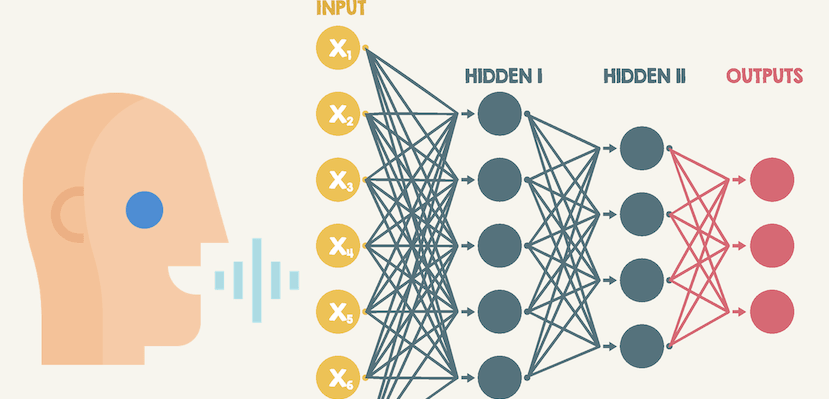

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [26]:
X_train_scaled = X_train_scaled.reshape(-1,16,8,1)
X_val_scaled = X_val_scaled.reshape(-1,16,8,1)
print("Shape of X_train and X_test: ", X_train_scaled.shape, X_val_scaled.shape)

Shape of X_train and X_test:  (1799, 16, 8, 1) (200, 16, 8, 1)


In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(16, 8, 1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = "same"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = "same"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = "same"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Reshape((16, -1)),
    tf.keras.layers.GRU(16, return_sequences=False),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 8, 16)         160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 4, 16)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 4, 16)          2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 2, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 2, 16)          2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 1, 16)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 2)            

In [42]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
cb = EarlyStopping(monitor='val_loss', patience = 5, verbose = 1)

In [44]:
history = model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled,y_val), callbacks=[cb])

Epoch 1/50
57/57 [==============================] - 5s 28ms/step - loss: 0.6685 - accuracy: 0.5520 - val_loss: 0.5961 - val_accuracy: 0.7850
Epoch 2/50
57/57 [==============================] - 1s 17ms/step - loss: 0.5358 - accuracy: 0.7626 - val_loss: 0.4048 - val_accuracy: 0.8350
Epoch 3/50
57/57 [==============================] - 1s 17ms/step - loss: 0.3664 - accuracy: 0.8421 - val_loss: 0.2769 - val_accuracy: 0.8800
Epoch 4/50
57/57 [==============================] - 1s 16ms/step - loss: 0.2717 - accuracy: 0.8961 - val_loss: 0.1784 - val_accuracy: 0.9350
Epoch 5/50
57/57 [==============================] - 1s 17ms/step - loss: 0.1892 - accuracy: 0.9266 - val_loss: 0.1448 - val_accuracy: 0.9500
Epoch 6/50
57/57 [==============================] - 1s 16ms/step - loss: 0.1341 - accuracy: 0.9533 - val_loss: 0.1014 - val_accuracy: 0.9700
Epoch 7/50
57/57 [==============================] - 1s 17ms/step - loss: 0.0936 - accuracy: 0.9666 - val_loss: 0.0879 - val_accuracy: 0.9750
Epoch 8/50
57

## Task 7: Evaluate the validation set

### Visualization

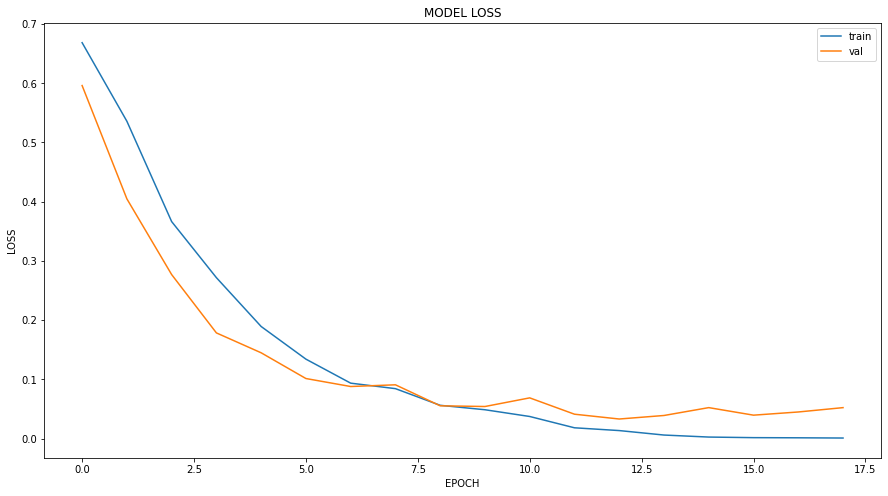

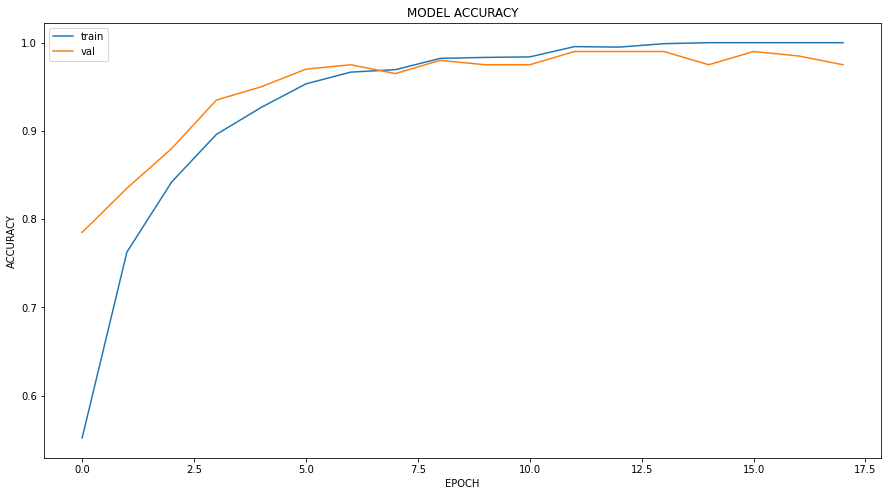

In [45]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.title('MODEL LOSS')
plt.legend(['train', 'val'])
plt.show()

plt.figure(figsize=(15,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.title('MODEL ACCURACY')
plt.legend(['train', 'val'])
plt.show()

In [46]:
ypred = model.predict(X_val_scaled)

## Task 8. Calculate and comment on ROC AUC score, recall score and confusion matrix.





In [47]:
roc_auc_score(y_val,ypred)

0.9990999099909991

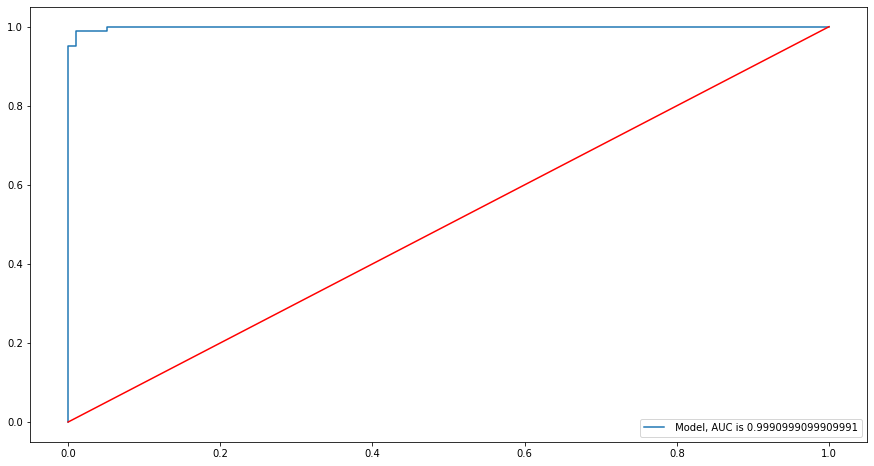

In [48]:
plt.figure(figsize=(15,8))
f, t, _ = roc_curve(y_val,  ypred)
AUC_score = roc_auc_score(y_val, ypred)
plt.plot(f,t,label=" Model, AUC is "+str(AUC_score))
plt.plot([0, 1], [0, 1], color="red")
plt.legend(loc=4)
plt.show()


### ROC AUC score is 98.5 99. The model is good enough as it is approximately 1, it distinguishes between  dysarthric and non dysarthric people well.

In [49]:
ypred[ypred>=0.5] = 1
ypred[ypred<0.5] = 0

### Recall Score

In [50]:
print("Recall Score ",recall_score(y_val,ypred))

Recall Score  0.9603960396039604



### Recall is the measure of correctly classified  dysarthric and non dysarthric people. The model is giving recall of 98.9% which is good enough.

### Classification Report

In [51]:
print(classification_report(y_val,ypred))


              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98        99
         1.0       0.99      0.96      0.97       101

    accuracy                           0.97       200
   macro avg       0.98      0.98      0.97       200
weighted avg       0.98      0.97      0.97       200



### Confusion Matrix



Testing Accuracy =  97.5


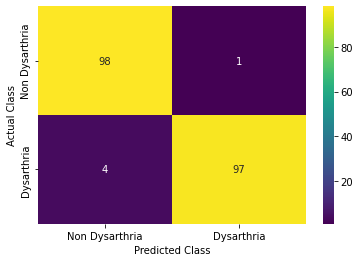

In [52]:

print("Testing Accuracy = ",accuracy_score(y_val,ypred)*100)
sns.heatmap(confusion_matrix(y_val, ypred),cmap='viridis',annot=True,fmt='.3g',
            xticklabels=['Non Dysarthria','Dysarthria'],yticklabels=['Non Dysarthria','Dysarthria'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()




#### No. of misclassifications:  1/103  from Non Dysarthia

#### No. of misclassifications:  2/97 from Dysarthia

### CONCLUSION: The model works well however it can be worked upon for further improvement.